### Module 7: Prediction Bus Arrival Times using Neural Networks

Exercise related to material in [AH2179-Exercise 7](https://github.com/zhenliangma/Applied-AI-in-Transportation/blob/main/Exercise_7_Neural_networks/Exercise7_Neural_Networks.ipynb).

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import numpy as np
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

filepath=""

sns.set(font_scale=0.5)

#### Data Preprocessing and Feature Engineering

In [2]:
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_7_Neural_networks/Exercise7data.csv'
df = pd.read_csv(url)
print(df.columns)
print(df.shape)
df.describe()

Index(['Arrival_time', 'Stop_id', 'Bus_id', 'Line_id', 'Arrival_delay',
       'Dwell_time', 'Scheduled_travel_time', 'Upstream_stop_delay',
       'Recurrent_delay'],
      dtype='object')
(4962, 9)


,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
count,4962.0,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000
mean,10261.0,43350.111044,3.546151,68.089077,6.050181,144.361548,65.501612,142.426994
std,0.0,1738.818774,0.497916,131.566125,11.581064,33.536165,124.418305,18.838942
min,10261.0,41343.000000,3.000000,-954.000000,0.000000,82.000000,-973.000000,95.654321
25%,10261.0,41725.000000,3.000000,-2.750000,0.000000,109.000000,12.000000,127.083758
50%,10261.0,44060.000000,4.000000,38.000000,0.000000,137.000000,28.000000,148.927466
75%,10261.0,45529.000000,4.000000,92.000000,12.000000,180.000000,67.000000,157.706508
max,10261.0,45780.000000,4.000000,1846.000000,259.000000,180.000000,1812.000000,172.865385


In [8]:
# transformed/deduced features
df['dt'] = df.Arrival_time.apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M'))
df['hour'] = df['dt'].apply(lambda x: x.hour)
df['date'] = df['dt'].dt.date
df['weekday'] = df['dt'].dt.dayofweek
df['upstream_delay_incl_dwell'] = df['Upstream_stop_delay'] + df['Dwell_time']
df['arrival_time_s'] = df['dt'].astype('int64') // 10**9
df['arrival_time_incl_avgdelay'] = df['arrival_time_s'] + df['Recurrent_delay']

# filter out unneeded attributes
df_filtered = df[['upstream_delay_incl_dwell', 'arrival_time_incl_avgdelay', 'arrival_time_s', 'Arrival_delay', 'Recurrent_delay', 'Dwell_time', 'Upstream_stop_delay', 'Scheduled_travel_time', 'hour', 'weekday']]
df_filtered = df_filtered.dropna()

# show correlation matrix
corr_matrix = df[df.columns[~df.columns.isin(['Arrival_time', 'dt', 'date'])]].corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

,Arrival_delay
Arrival_delay,1.000000
upstream_delay_incl_dwell,0.949788
Upstream_stop_delay,0.941217
weekday,0.084526
Dwell_time,0.060793
hour,0.050717
Recurrent_delay,0.024228
arrival_time_incl_avgdelay,0.012420
arrival_time_s,0.012419
Line_id,0.011076


Create 3 different data input sets to investigate the effect of feature engineering on the model's performance:
- All features without any preprocessing
- Subset of features
- Subset of transformed features and scaling

In [91]:
# option one (all original features from the dataset):
X_simple = df[['Stop_id', 'Bus_id', 'Line_id', 'Dwell_time', 'Scheduled_travel_time', 'Upstream_stop_delay','Recurrent_delay']]
y_simple = df['Arrival_delay']
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)

# option two (subset of original features, i.e. those with highest correlation)
X_subset = df[['Dwell_time', 'Scheduled_travel_time', 'Upstream_stop_delay']]
y_subset = df['Arrival_delay']
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# option three (transformed and scaled)
X_ts = df[['upstream_delay_incl_dwell', 'Scheduled_travel_time', 'Recurrent_delay', 'hour']]
y_ts = df['Arrival_delay']
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_ts, y_ts, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_ts = scaler.fit_transform(X_train_ts)
X_test_ts = scaler.transform(X_test_ts)

datasets = {
    'simple': (X_train_simple, X_test_simple, y_train_simple, y_test_simple),
    'subset': (X_train_subset, X_test_subset, y_train_subset, y_test_subset),
    'transformed': (X_train_ts, X_test_ts, y_train_ts, y_test_ts),
}

#### Benchmarking with Linear Regression

In [92]:
from sklearn.linear_model import LinearRegression

output_df_linear = pd.DataFrame(columns=['input_data', 'MAE', 'MSE', 'R2'])

# loop through the datasets
dataset_count = -1
for (X_train, X_test, y_train, y_test) in datasets.values():
  dataset_count += 1

  # linear regression for benchmarking
  model_linear = LinearRegression()
  model_linear.fit(X_train, y_train)
  y_pred_linear = model_linear.predict(X_test)

  mae_linear = mean_absolute_error(y_test, y_pred_linear)
  mse_linear = mean_squared_error(y_test, y_pred_linear)
  r2_linear = r2_score(y_test, y_pred_linear)

  output_df_linear.loc[len(output_df_linear)] = [
          list(datasets.keys())[dataset_count],
          mae_linear,
          mse_linear,
          r2_linear
      ]

output_df_linear.sort_values(by='R2', ascending=False)

,input_data,MAE,MSE,R2
2,transformed,28.265785,1294.117864,0.915089
0,simple,28.263602,1298.613887,0.914794
1,subset,29.334142,1375.768439,0.909731


#### Network Construction and Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


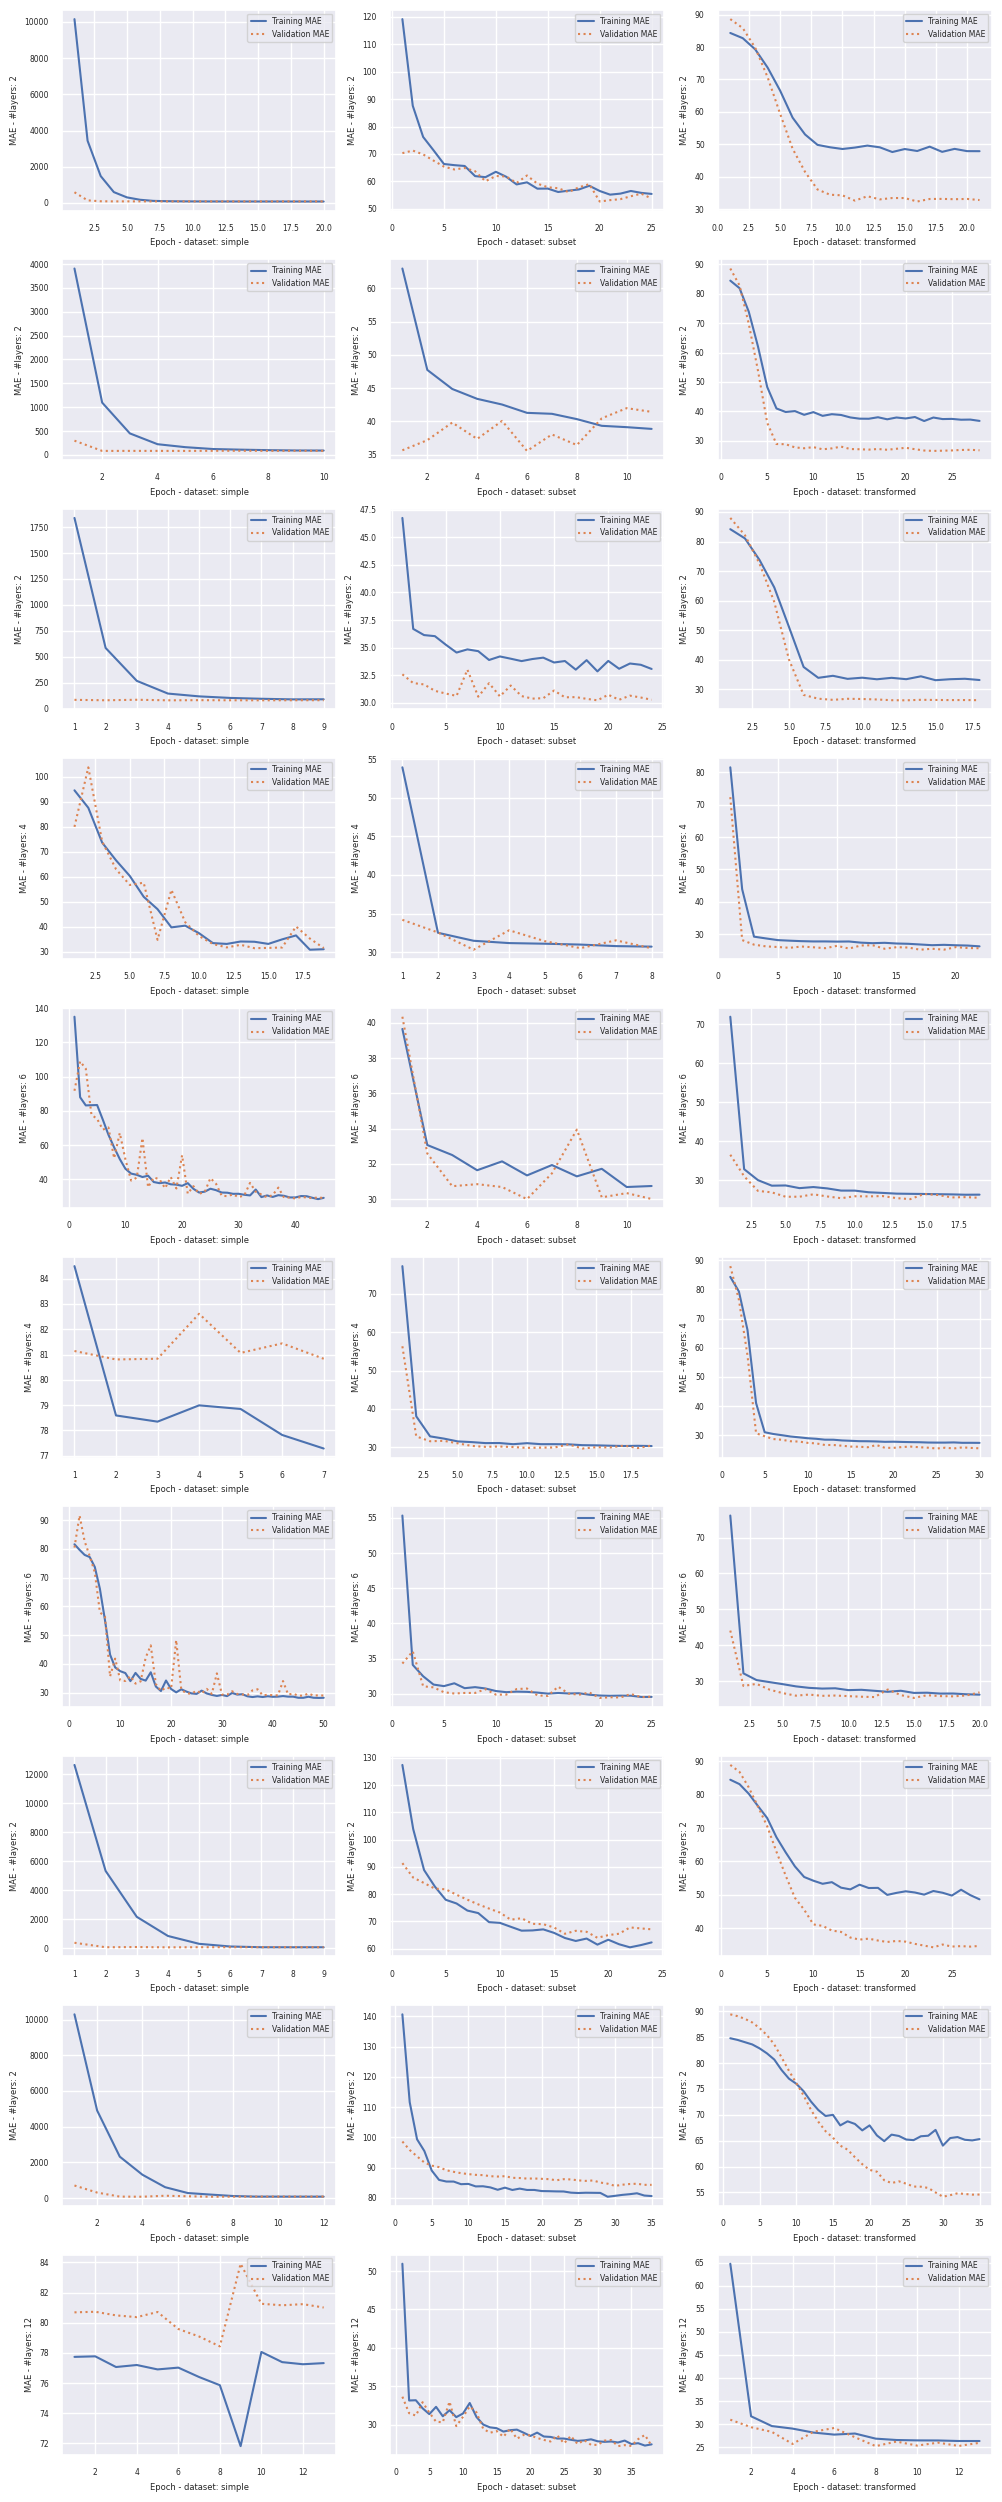

In [85]:
fig, ax = plt.subplots(10, 3, figsize=(10, 25))
output_df = pd.DataFrame(columns=['input_data', 'n_layers', 'neuron_config', 'dropout_rate', 'MAE', 'MSE', 'R2'])

# variables to vary:
nn_params = {
    'n_layers': [2, 4, 6, 12],
    'n_neurons': [8, 32, 64],
    'dropout_rate': [0, 0.2, 0.5, 0.8],
}

# try 10 different random configurations
for iter in range(10):

    # randomly sample parameters
    sampled_params = dict()
    for param, vals in nn_params.items():
      sampled_params[param] = random.choice(vals)

    # loop through the datasets
    dataset_count = -1
    for (X_train, X_test, y_train, y_test) in datasets.values():
      dataset_count += 1

      n_dimensions = X_train.shape[1]

      # model construction
      model = Sequential()
      neuron_config = []

      for layer in range(sampled_params['n_layers']):
        curr_n_neurons = int(sampled_params['n_neurons']*random.choice([0.5, 1, 2]))
        neuron_config.append(curr_n_neurons)

        if layer == 0:
          model.add(Dense(curr_n_neurons, activation='relu', input_dim=n_dimensions))
        else:
          model.add(Dense(curr_n_neurons, activation='relu'))

        model.add(Dropout(sampled_params['dropout_rate']))

      model.add(Dense(1))
      model.compile(optimizer='adam', loss='mae', metrics=['mae'])

      # model training
      early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
      reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
      filepath = "weights.best.h5.keras"
      checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=0, save_best_only=True, mode='min')
      hist = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)

      # model evaluation
      err = hist.history['mae']
      val_err = hist.history['val_mae']
      epochs = range(1, len(err) + 1)
      ax[iter, dataset_count].plot(epochs, err, '-', label='Training MAE')
      ax[iter, dataset_count].plot(epochs, val_err, ':', label='Validation MAE')
      ax[iter, dataset_count].set_xlabel('Epoch - dataset: ' + list(datasets.keys())[dataset_count])
      ax[iter, dataset_count].set_ylabel('MAE - #layers: '+ str(sampled_params['n_layers']))
      ax[iter, dataset_count].legend(loc='upper right')

      # Use the trained model to predict on the test data.
      y_pred = model.predict(X_test)
      mae = mean_absolute_error(y_test, y_pred)
      mse = mean_squared_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)

      output_df.loc[len(output_df)] = [
          list(datasets.keys())[dataset_count],
          sampled_params['n_layers'],
          neuron_config,
          sampled_params['dropout_rate'],
          mae,
          mse,
          r2
      ]


fig.tight_layout()

#### Results Analysis

In [126]:
output_df['n_neurons'] = output_df['neuron_config'].apply(lambda x: np.sum(x))
output_df.sort_values(by='R2', ascending=False)

,input_data,n_layers,neuron_config,dropout_rate,MAE,MSE,R2,n_neurons
20,transformed,6,"[64, 16, 64, 16, 16, 32]",0.0,28.195335,1390.286802,0.908779,208
29,transformed,12,"[32, 32, 64, 32, 32, 64, 32, 16, 32, 16, 16, 32]",0.0,28.239711,1405.687327,0.907768,400
12,simple,6,"[32, 64, 128, 64, 32, 32]",0.0,30.318211,1437.271171,0.905696,352
14,transformed,6,"[32, 32, 32, 32, 64, 64]",0.0,28.414815,1453.595489,0.904625,256
28,subset,12,"[64, 64, 16, 32, 64, 64, 64, 32, 32, 16, 64, 16]",0.0,29.706257,1457.552163,0.904365,528
11,transformed,4,"[32, 32, 32, 32]",0.0,28.394020,1485.751597,0.902515,128
18,simple,6,"[16, 16, 16, 16, 32, 64]",0.0,30.052107,1492.867824,0.902048,160
19,subset,6,"[32, 16, 64, 16, 16, 16]",0.0,31.671804,1630.850776,0.892994,160
9,simple,4,"[64, 16, 32, 64]",0.0,31.904219,1669.410391,0.890464,176
7,subset,2,"[64, 64]",0.2,32.381804,1728.348136,0.886597,128


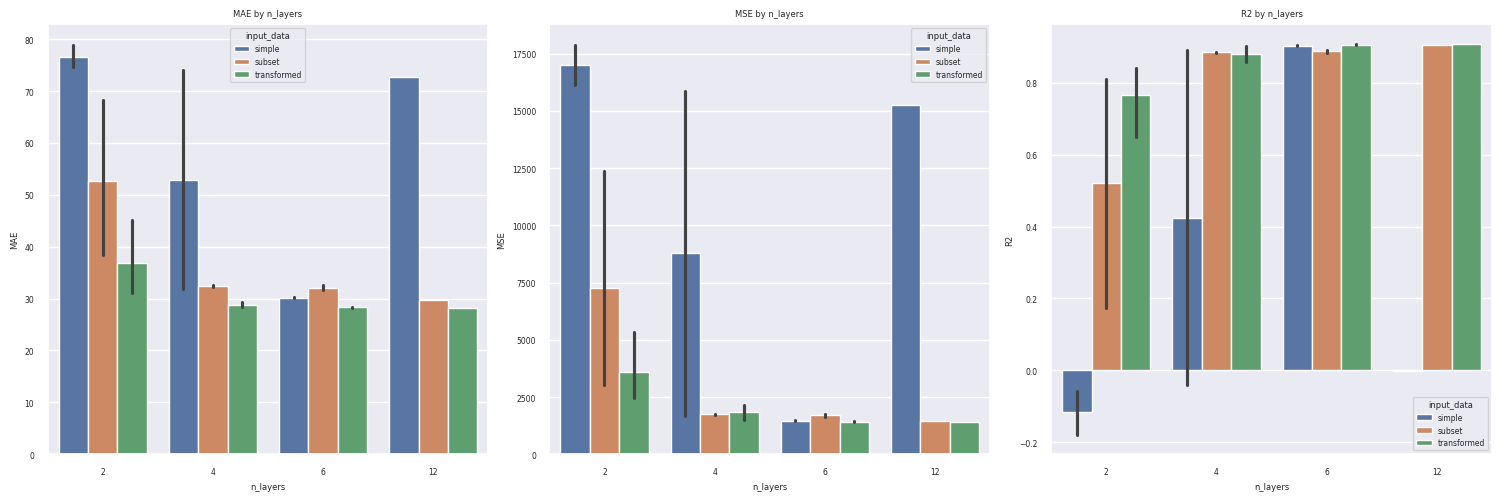

In [119]:
fig2, ax2 = plt.subplots(1, 3, figsize=(15, 5))

for i, e in enumerate(['MAE', 'MSE', 'R2']):
    sns.barplot(
        x="n_layers",
        y=e,
        hue="input_data",
        data=output_df,
        ax=ax2[i]
    )
    ax2[i].set_title(f'{e} by n_layers')

plt.tight_layout()
plt.show()

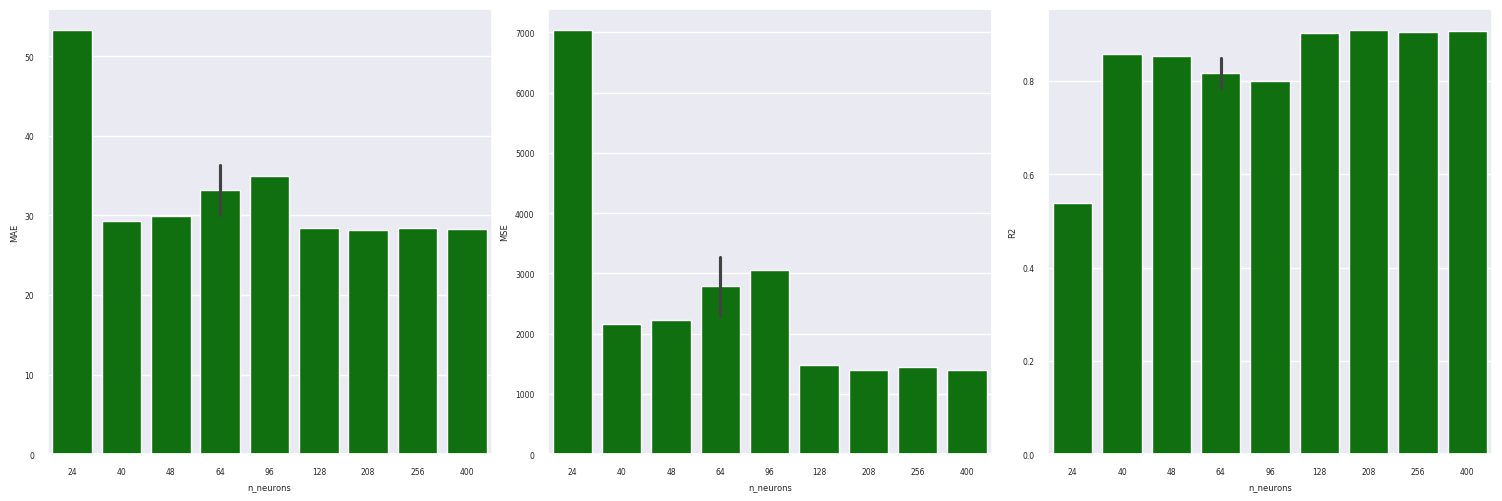

In [127]:
fig2, ax2 = plt.subplots(1, 3, figsize=(15, 5))
df_extend = output_df[output_df.input_data =='transformed']

for i, e in enumerate(['MAE', 'MSE', 'R2']):
    sns.barplot(
        x="n_neurons",
        y=e,
        data=df_extend,
        ax=ax2[i],
        color='green'
    )

plt.tight_layout()
plt.show()

In [125]:
df_extend[(df_extend.n_neurons >= 128)]

,input_data,n_layers,neuron_config,dropout_rate,MAE,MSE,R2,n_neurons
11,transformed,4,"[32, 32, 32, 32]",0.0,28.394020,1485.751597,0.902515,128
14,transformed,6,"[32, 32, 32, 32, 64, 64]",0.0,28.414815,1453.595489,0.904625,256
20,transformed,6,"[64, 16, 64, 16, 16, 32]",0.0,28.195335,1390.286802,0.908779,208
29,transformed,12,"[32, 32, 64, 32, 32, 64, 32, 16, 32, 16, 16, 32]",0.0,28.239711,1405.687327,0.907768,400
